Convert Pascal VOC training data to Haar training data

In [1]:
import os

In [7]:
def create_boxes(filename):
    boxes = []

    input = open(filename, 'r')
    lines = input.readlines()

    for i, line in enumerate(lines):
        if 'xmin' in line:
            line2, line3, line4 = lines[i + 1], lines[i + 2], lines[i + 3]
            
            xmin = int(line[9:-8])
            ymin = int(line2[9:-8])
            xmax = int(line3[9:-8])
            ymax = int(line4[9:-8])
            
            x, y = xmin, ymin
            width = xmax - xmin 
            height = ymax - ymin
            
            boxes.append(str(x) + ' ' + str(y) + ' ' +  str(width) + ' ' + str(height))
    
    return boxes

In [ ]:
def draw_rectangles(haystack_img, rectangles):
    # these colors are actually BGR
    line_color = (0, 255, 0)
    line_type = cv2.LINE_4

    count = 0
    for (x, y, w, h) in rectangles:
        if w > 60 or h > 60:
            continue
        count += 1
        # determine the box positions
        top_left = (x, y)
        bottom_right = (x + w, y + h)
        # draw the box
        cv2.rectangle(haystack_img, top_left, bottom_right, line_color, lineType=line_type)

    return haystack_img, count

In [8]:
def create_pos_txt(pascal_training_X):
    all_boxes = []
    with open('pos.txt', 'w') as f:
        for x in pascal_training_X:
            boxes = create_boxes(x)
            f.write('positive/' + x[x.rfind('/') + 1:-3] + 'jpg ' + str(len(boxes)))
            for box in boxes:
                f.write(' ' + box)
            f.write('\n')
            all_boxes.extend(boxes)
    return all_boxes

In [9]:
def create_neg_txt(directory):
    with open('neg.txt', 'w') as f:
        for filename in os.listdir(directory):
            f.write('negative/' + filename + '\n')

In [10]:
pascal_training_X = [
    '../labeling_real/annotations/2021_07_19/E3-A.xml',
    '../labeling_real/annotations/2021_07_19/P6-C.xml',
    '../labeling_real/annotations/2021_08_05/ECages/E8_B.xml',
    '../labeling_real/annotations/2021_08_05/PCages/P9_A.xml',
    '../labeling_real/annotations/2021_08_20/ECage/E9_A.xml',
    '../labeling_real/annotations/2021_08_20/PCage/P6_C.xml',
    '../labeling_real/annotations/2021_09_17/IMG_2009.xml',
    '../labeling_real/annotations/Census 2021/10-18/IMG_6550.xml'
]

In [14]:
all_boxes = create_pos_txt(pascal_training_X)
create_neg_txt('./negative')

Object Detection Model

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import timeit

In [6]:
def draw_rectangles(haystack_img, rectangles):
    # these colors are actually BGR
    line_color = (0, 255, 0)
    line_type = cv2.LINE_4

    count = 0
    for (x, y, w, h) in rectangles:
        if w > 60 or h > 60:
            continue
        count += 1
        # determine the box positions
        top_left = (x, y)
        bottom_right = (x + w, y + h)
        # draw the box
        cv2.rectangle(haystack_img, top_left, bottom_right, line_color, lineType=line_type)

    return haystack_img, count

In [7]:
def k_means(img):   
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.cvtColor(blur,cv2.COLOR_BGR2RGB)
    twoDimage = img.reshape((-1,3))
    twoDimage = np.float32(twoDimage)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    attempts = 1
    ret,label,center=cv2.kmeans(twoDimage,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img.shape))   
    return result_image

def contour_detect(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (11, 11), 0)
    canny = cv2.Canny(blur, 0, 0, 3, L2gradient=True)
    dilated = cv2.dilate(canny, (5,5), iterations=50)

    (contours, hierarchy) = cv2.findContours(dilated.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    sorted_contours= sorted(contours, key=cv2.contourArea, reverse=True)
    
    cv2.drawContours(img, contours, -1, (0, 255, 0), 2)
    cv2.drawContours(img, sorted_contours, 0, (255, 0, 0), 2)
    return img, sorted_contours

def segment_corner(img):
#     img = cv2.imread(filename) # Read in your image
    k_means_img = k_means(img)
    contours_img, contours = contour_detect(k_means_img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    mask = np.zeros_like(thresh)
    cv2.drawContours(mask, contours, 0, 255, -1) # Draw filled contour in mask
    out = np.zeros_like(img) # Extract out the object and place into output image
    out[mask == 255] = img[mask == 255]
    
    # Now crop
    (y, x) = np.where(mask == 255)
    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))
    out = out[topy:bottomy+1, topx:bottomx+1]

    return out

In [34]:
def createDetectionFile(i, rectangles):
    with open(str(i) + '.txt', 'w') as f:
        for rect in rectangles:
                x, y, w, h = rect
                if w > 60 or h > 60:
                    continue
                str_rect = [str(x) for x in rect]
                box = " ".join(str_rect)
                f.write("fly 1 " + box + "\n")

In [35]:
cascade_fly = cv2.CascadeClassifier('cascade/cascade.xml')

In [36]:
def detect_flies(filename, output_name):
    print("BEGIN " + filename)
    start = timeit.default_timer()
    
    img = cv2.imread(filename) # Read in your image
    cropped_img = segment_corner(img)
    print("Cropped " + filename)
    
    rectangles = cascade_fly.detectMultiScale(cropped_img)
#     createDetectionFile(rectangles)
    print("Performed detection for " + filename)
    
    detection_image, count = draw_rectangles(cropped_img, rectangles)
    print("# of Drosophila:  " + str(count))
    
    cv2.imwrite(output_name, detection_image)
    
    stop = timeit.default_timer()
    print('Time: ', stop - start)  
    print("FINISHED " + filename + "\n")
    
    return detection_image, rectangles

Using Object Detection Model

In [37]:
directory = "./positive"
for i, filename in enumerate(os.listdir(directory)):
    f = os.path.join(directory, filename)
    image, rectangles = detect_flies(f, "model_v1.1_" + filename)
    createDetectionFile(i, rectangles)

BEGIN ./positive/E3-A.JPG
Cropped ./positive/E3-A.JPG
Performed detection for ./positive/E3-A.JPG
# of Drosophila:  199
Time:  2.031054499999982
FINISHED ./positive/E3-A.JPG

BEGIN ./positive/E8_B.JPG
Cropped ./positive/E8_B.JPG
Performed detection for ./positive/E8_B.JPG
# of Drosophila:  343
Time:  4.351375499999904
FINISHED ./positive/E8_B.JPG

BEGIN ./positive/E9_A.JPG
Cropped ./positive/E9_A.JPG
Performed detection for ./positive/E9_A.JPG
# of Drosophila:  208
Time:  2.6580430000001343
FINISHED ./positive/E9_A.JPG

BEGIN ./positive/IMG_2009.jpeg
Cropped ./positive/IMG_2009.jpeg
Performed detection for ./positive/IMG_2009.jpeg
# of Drosophila:  2
Time:  2.39857290000009
FINISHED ./positive/IMG_2009.jpeg

BEGIN ./positive/IMG_6427.jpg
Cropped ./positive/IMG_6427.jpg
Performed detection for ./positive/IMG_6427.jpg
# of Drosophila:  247
Time:  1.241199800000004
FINISHED ./positive/IMG_6427.jpg

BEGIN ./positive/IMG_6550.jpg
Cropped ./positive/IMG_6550.jpg
Performed detection for ./pos

### --- EXPERIMENTAL CODE BELOW --- 
Cropping Methods

In [14]:
def k_means(img):   
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.cvtColor(blur,cv2.COLOR_BGR2RGB)
    twoDimage = img.reshape((-1,3))
    twoDimage = np.float32(twoDimage)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    attempts = 1
    ret,label,center=cv2.kmeans(twoDimage,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img.shape))   
    return result_image

def contour_detect(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (11, 11), 0)
    canny = cv2.Canny(blur, 0, 0, 3, L2gradient=True)
    dilated = cv2.dilate(canny, (5,5), iterations=50)

    (contours, hierarchy) = cv2.findContours(dilated.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    sorted_contours= sorted(contours, key=cv2.contourArea, reverse=True)
    
    cv2.drawContours(img, contours, -1, (0, 255, 0), 2)
    cv2.drawContours(img, sorted_contours, 0, (255, 0, 0), 2)
    return img, sorted_contours

def segment_corner(img):
#     img = cv2.imread(filename) # Read in your image
    k_means_img = k_means(img)
    contours_img, contours = contour_detect(k_means_img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    mask = np.zeros_like(thresh)
    cv2.drawContours(mask, contours, 0, 255, -1) # Draw filled contour in mask
    out = np.zeros_like(img) # Extract out the object and place into output image
    out[mask == 255] = img[mask == 255]
    
    # Now crop
    (y, x) = np.where(mask == 255)
    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))
    out = out[topy:bottomy+1, topx:bottomx+1]

    return out

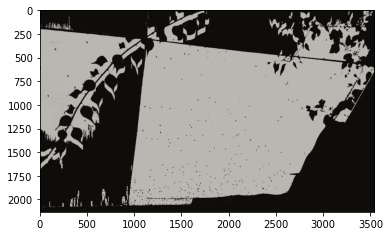

In [55]:
# blur = cv2.GaussianBlur(crop_img, (5, 5), 0)
# img = cv2.cvtColor(blur,cv2.COLOR_BGR2RGB)
# twoDimage = img.reshape((-1,3))
# twoDimage = np.float32(twoDimage)

# criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# K = 2
# attempts = 1
# ret,label,center=cv2.kmeans(twoDimage,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

# center = np.uint8(center)
# res = center[label.flatten()]
# result_image = res.reshape((img.shape))
# plt.imshow(result_image)

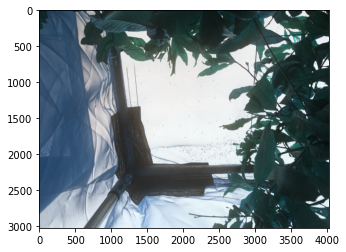

In [149]:
filename = os.listdir(directory)[0]
f = os.path.join(directory, filename)
img = cv2.imread(f)
# crop_img = segment_corner(img)
plt.imshow(img)

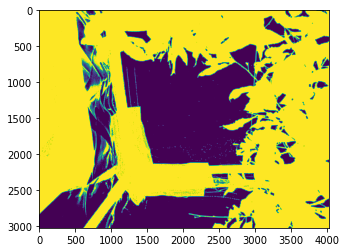

In [151]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(thresh)

In [212]:
lower = [0, 0, 0]
upper = [0, 0, 0]

# create NumPy arrays from the boundaries
lower = np.array(lower, dtype="uint8")
upper = np.array(upper, dtype="uint8")

mask = cv2.inRange(thresh, lower, upper)
output = cv2.bitwise_and(img, img, mask=thresh)
plt.imshow(output)

error: OpenCV(4.5.4) /tmp/pip-req-build-21t5esfk/opencv/modules/core/src/arithm.cpp:1741: error: (-209:Sizes of input arguments do not match) The lower boundary is neither an array of the same size and same type as src, nor a scalar in function 'inRange'


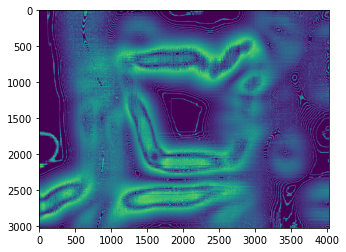

In [204]:
# gray = cv2.cvtColor(result_image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(thresh, (1001, 1001), 0)
# plt.imshow(blur)

canny = cv2.Canny(blur, 0, 0, 3, L2gradient=True)
dilated = cv2.dilate(canny, (5,5), iterations=1)

(contours, hierarchy) = cv2.findContours(dilated.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

sorted_contours= sorted(contours, key=cv2.contourArea, reverse=True)

# cv2.drawContours(img, contours, -1, (0, 255, 0), 2)
# cv2.drawContours(img, sorted_contours, 0, (255, 0, 0), 2)
plt.imshow(dilated)

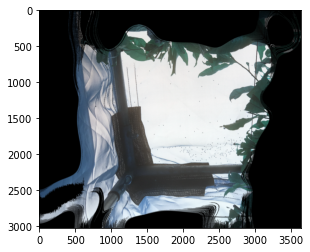

In [203]:
#     img = cv2.imread(filename) # Read in your image
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
mask = np.zeros_like(thresh)
cv2.drawContours(mask, sorted_contours, 0, 255, -1) # Draw filled contour in mask
out = np.zeros_like(img) # Extract out the object and place into output image
out[mask == 255] = img[mask == 255]

# Now crop
(y, x) = np.where(mask == 255)
(topy, topx) = (np.min(y), np.min(x))
(bottomy, bottomx) = (np.max(y), np.max(x))
out = out[topy:bottomy+1, topx:bottomx+1]

plt.imshow(out)

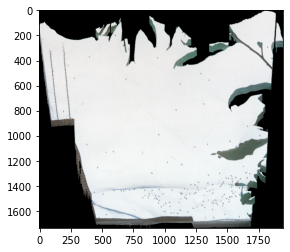

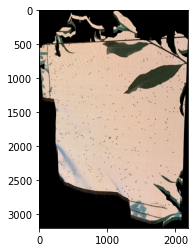

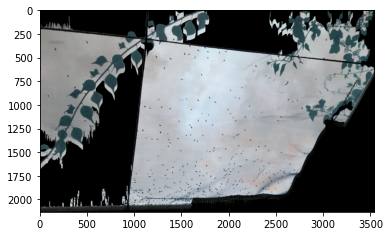

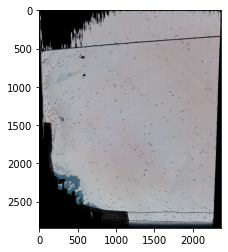

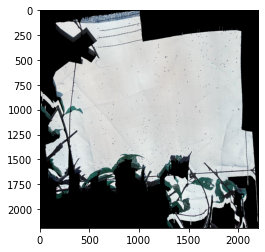

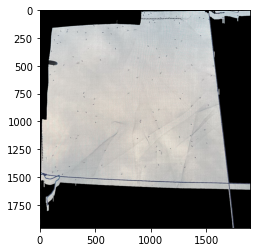

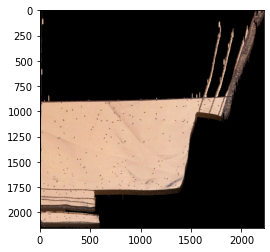

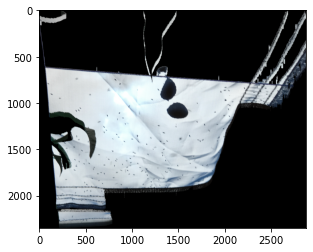

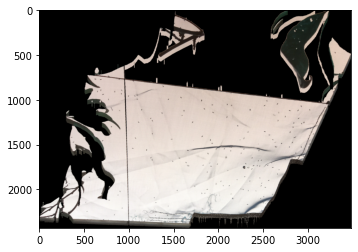

In [49]:
directory = "./positive"

images = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    img = cv2.imread(f)
    crop_img = segment_corner(img)
    images.append(crop_img)

for ima in images:
    plt.figure()
    plt.imshow(ima)

### NOT IN USE
The code below are discarded methods not currenlty being explored

In [29]:
def crop_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY_INV)
    
    contours, hiers = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    parent = hiers[0, :, 3]
    hist = np.bincount(np.maximum(parent, 0))
    max_n_childs_idx = hist.argmax()
    
    mask = np.zeros_like(thresh) # Create mask where white is what we want, black otherwise
    cv2.drawContours(mask, contours, max_n_childs_idx, 255, -1) # Draw filled contour in mask
    out = np.zeros_like(img) # Extract out the object and place into output image
    out[mask == 255] = img[mask == 255]

    # Now crop
    (y, x) = np.where(mask == 255)
    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))
    out = out[topy:bottomy+1, topx:bottomx+1]
    
    return out